In [255]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [256]:
#open pretrained models for predicting delta y
sj_model = joblib.load('sj_rf.pkl')
iq_model = joblib.load('iq_rf.pkl')

In [257]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="quadratic", order=1)

    if labels is not None:
        features['delta_y'] = sj_model.predict(features.drop('total_cases', axis=1))
    else:
        features['delta_y'] = sj_model.predict(features)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)


def iq_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="quadratic", order=1)

    if labels is not None:
        features['delta_y'] = iq_model.predict(features.drop('total_cases', axis=1))
    else:
        features['delta_y'] = iq_model.predict(features)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)

In [258]:
tminus = 1
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=tminus,
                                                        iq_tminus=tminus)

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [259]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)


In [260]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_ne,655.0,0.086158,0.096638,-0.290200,0.032292,0.082800,0.129210,0.446267
ndvi_nw,655.0,0.084960,0.106930,-0.567938,0.044733,0.085600,0.134550,0.437100
ndvi_se,655.0,0.170185,0.094370,-0.556810,0.140464,0.177643,0.212529,0.393129
ndvi_sw,655.0,0.163893,0.063279,-0.111362,0.129112,0.167943,0.203043,0.381420
precipitation_amt_mm,655.0,34.365767,41.398842,-15.492810,0.705000,21.530000,50.610000,287.550000
reanalysis_air_temp_k,655.0,299.020389,1.181711,295.938571,298.015714,299.215714,299.980714,301.255714
reanalysis_avg_temp_k,655.0,299.128194,1.159116,296.114286,298.160714,299.314286,300.053571,301.407143
reanalysis_dew_point_temp_k,655.0,295.064769,1.568129,289.642857,293.820714,295.447143,296.355714,297.467143
reanalysis_max_air_temp_k,655.0,301.255595,1.199172,298.200000,300.400000,301.400000,302.300000,303.900000


In [261]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,364.0,26.431319,14.973924,1.000000,13.750000,26.000000,39.000000,53.000000
ndvi_ne,364.0,0.267057,0.081455,0.088616,0.204575,0.267829,0.323507,0.488400
ndvi_nw,364.0,0.233889,0.075983,0.035860,0.178186,0.226736,0.289986,0.428771
ndvi_se,364.0,0.251451,0.076860,0.029880,0.195130,0.250836,0.305611,0.473400
ndvi_sw,364.0,0.264058,0.083723,0.064183,0.206225,0.261300,0.321064,0.546017
precipitation_amt_mm,364.0,64.413590,34.986159,0.000000,39.452500,60.850000,86.507500,173.450000
reanalysis_air_temp_k,364.0,297.856586,1.193372,294.635714,297.062857,297.822857,298.588214,301.637143
reanalysis_avg_temp_k,364.0,299.129271,1.346382,294.892857,298.217857,299.121429,300.108929,302.928571
reanalysis_dew_point_temp_k,364.0,295.318981,1.478115,290.088571,294.344643,295.740000,296.457857,297.852857
reanalysis_max_air_temp_k,364.0,307.190040,2.456329,300.000000,305.200000,307.200000,308.900000,314.000000


In [262]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

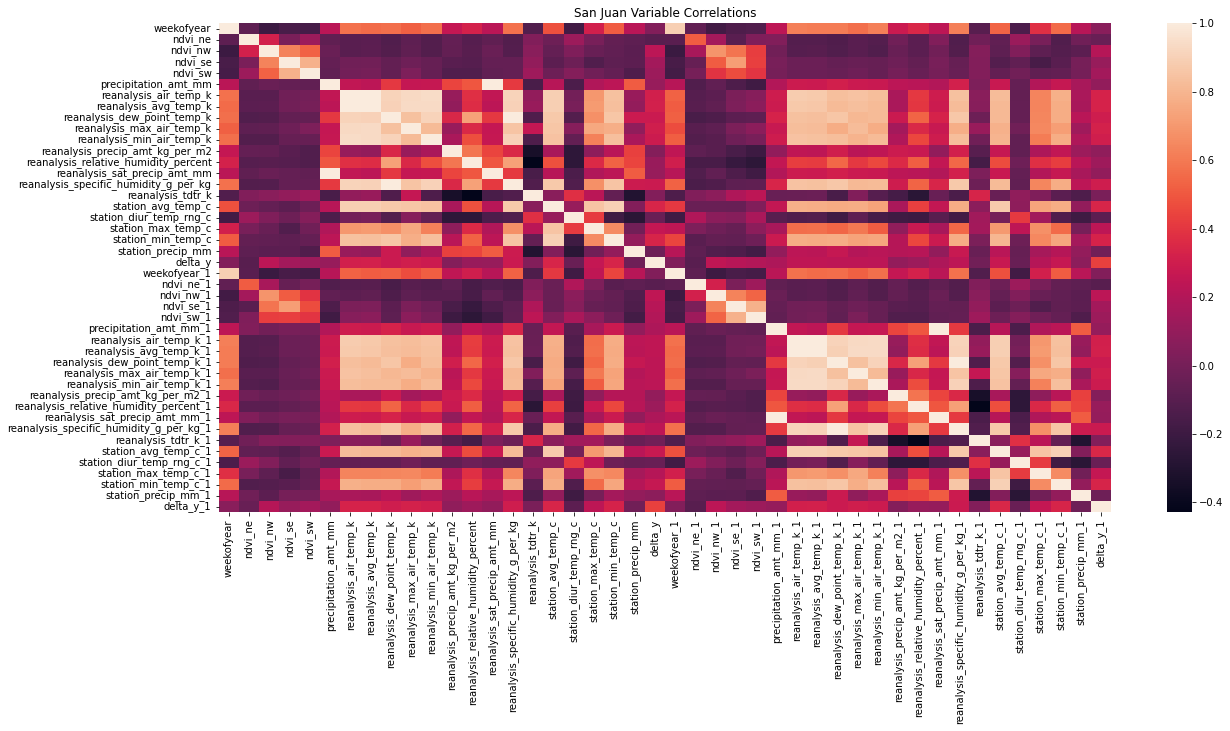

In [263]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [264]:
'''def chain_predict(model,x):
    #need to used last predicted y as input for next prediction
    xt = x.copy()
    preds = []
    #ser previous cases to zero
    xt['prev_total_cases'] = 0.0
    #make first prediction taking preset zero 
    #an update next column with prediction

    for i in range(xt.shape[0]):
        yt = model.predict([xt.iloc[i]])
        if i+1 < xt.shape[0]:
            xt['prev_total_cases'].iloc[i+1] = yt
        preds.append(yt[0])

    return preds'''

"def chain_predict(model,x):\n    #need to used last predicted y as input for next prediction\n    xt = x.copy()\n    preds = []\n    #ser previous cases to zero\n    xt['prev_total_cases'] = 0.0\n    #make first prediction taking preset zero \n    #an update next column with prediction\n\n    for i in range(xt.shape[0]):\n        yt = model.predict([xt.iloc[i]])\n        if i+1 < xt.shape[0]:\n            xt['prev_total_cases'].iloc[i+1] = yt\n        preds.append(yt[0])\n\n    return preds"

In [265]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

10.978881234640339
23.65176226156876


In [266]:
sj_rf.feature_importances_

array([1.24321293e-02, 2.62862576e-03, 2.78946155e-02, 4.81086572e-01,
       3.49308635e-03, 1.55047341e-03, 1.47209900e-03, 1.45859098e-03,
       3.73162029e-03, 1.15412559e-03, 2.41771056e-03, 4.31745915e-03,
       2.71339047e-03, 5.21487998e-04, 3.31531887e-03, 2.60356778e-03,
       3.23368716e-03, 2.25761007e-03, 7.97431596e-04, 4.52016415e-04,
       2.12188694e-03, 1.47338726e-01, 4.37357457e-02, 3.82418960e-03,
       9.58833912e-03, 1.06470505e-01, 1.22765733e-03, 1.15528925e-03,
       9.50675401e-04, 1.06806746e-03, 2.52978788e-03, 9.64890937e-04,
       1.71295413e-03, 4.78906914e-03, 3.86978808e-03, 8.51305154e-04,
       1.65740333e-03, 2.78497682e-03, 1.28681165e-03, 1.79206568e-03,
       5.03594247e-04, 9.43086969e-04, 2.37421737e-03, 9.69273493e-02])

<AxesSubplot:ylabel='cols'>

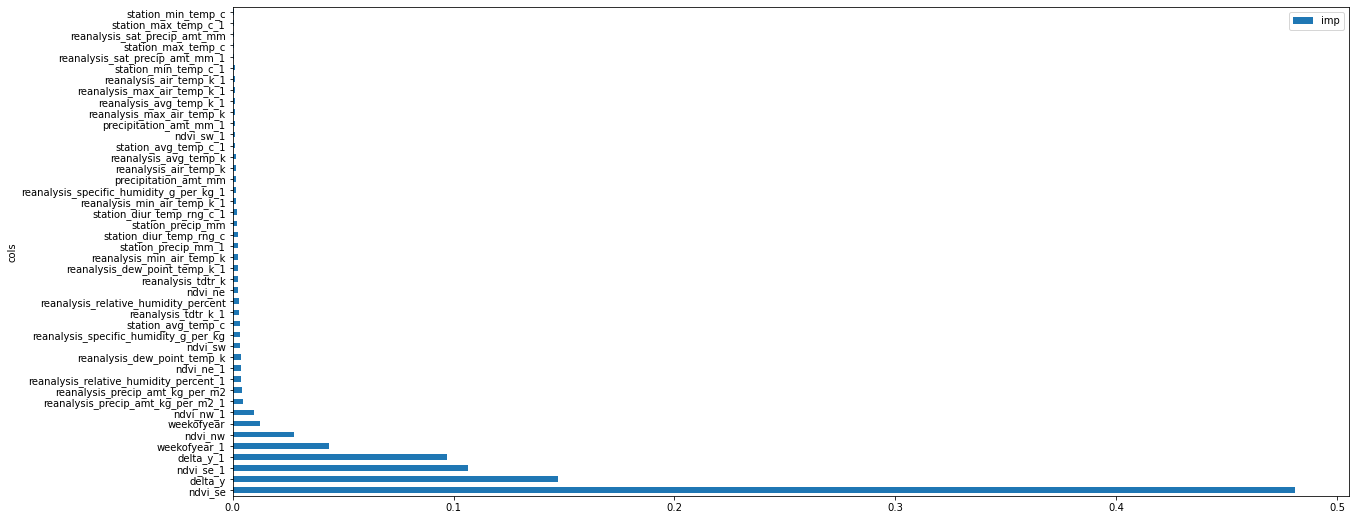

In [267]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [268]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

2.9650994950716854
7.616556718769552


In [269]:
iq_rf.feature_importances_

array([0.0053652 , 0.01470833, 0.01392875, 0.0130392 , 0.00754372,
       0.00627773, 0.00332404, 0.00784286, 0.01957064, 0.00330551,
       0.0122732 , 0.01097745, 0.00464042, 0.00751105, 0.00972343,
       0.00325081, 0.00700951, 0.01168336, 0.00897781, 0.02200332,
       0.01413112, 0.49842187, 0.0102815 , 0.00661224, 0.01238343,
       0.00585178, 0.00501714, 0.00695623, 0.00378183, 0.00606964,
       0.01495646, 0.005726  , 0.01268468, 0.00604505, 0.00437189,
       0.00638419, 0.00854485, 0.00556579, 0.00898625, 0.01025028,
       0.00771367, 0.00604153, 0.01264305, 0.12762323])

<AxesSubplot:ylabel='cols'>

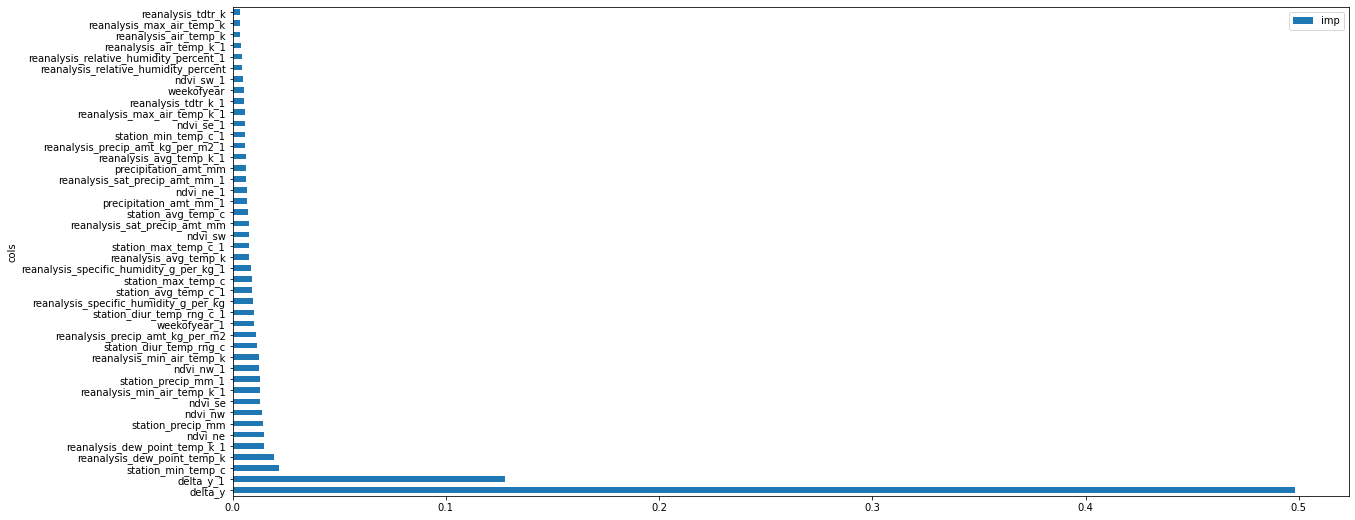

In [270]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

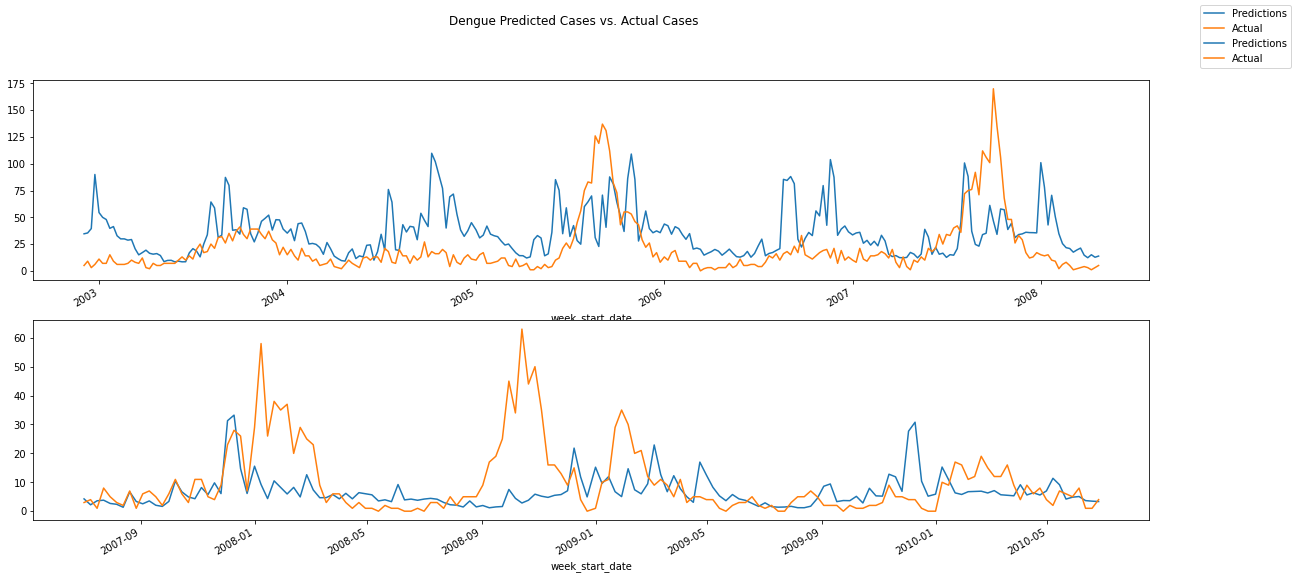

In [271]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [272]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [273]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                        sj_tminus=tminus,
                                        iq_tminus=tminus) 

In [274]:
sj_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent_1,reanalysis_sat_precip_amt_mm_1,reanalysis_specific_humidity_g_per_kg_1,reanalysis_tdtr_k_1,station_avg_temp_c_1,station_diur_temp_rng_c_1,station_max_temp_c_1,station_min_temp_c_1,station_precip_mm_1,delta_y_1
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,81.641275,144.351787,16.862119,2.820513,28.008432,5.971942,32.228571,23.412501,109.696607,0.491014
2008-05-06,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,78.781429,78.600000,15.918571,3.128571,26.528571,7.057143,33.300000,21.700000,75.200000,2.053567
2008-05-13,20,-0.001500,-0.031051,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,78.230000,12.560000,15.791429,2.571429,26.071429,5.557143,30.000000,22.200000,34.300000,-0.649876
2008-05-20,21,0.052862,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,78.270000,3.660000,16.674286,4.428571,27.928571,7.785714,32.800000,22.800000,3.000000,2.593387
2008-05-27,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,73.015714,0.000000,15.775714,4.342857,28.057143,6.271429,33.300000,24.400000,0.300000,3.155893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,...,68.181429,0.000000,12.705714,3.057143,25.842857,6.471429,29.400000,21.700000,4.800000,-0.082974
2013-04-02,14,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,...,78.780000,30.340000,15.985714,3.314286,27.542857,7.942857,33.900000,22.800000,3.500000,0.682683
2013-04-09,15,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,...,81.650000,6.550000,15.881429,2.828571,26.642857,6.642857,33.300000,22.800000,17.600000,1.593756


In [275]:
iq_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent_1,reanalysis_sat_precip_amt_mm_1,reanalysis_specific_humidity_g_per_kg_1,reanalysis_tdtr_k_1,station_avg_temp_c_1,station_diur_temp_rng_c_1,station_max_temp_c_1,station_min_temp_c_1,station_precip_mm_1,delta_y_1
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,...,100.385889,138.663221,15.839552,10.137883,27.666269,9.754911,33.782618,21.298283,13.312169,-0.458789
2010-07-09,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,...,92.581429,82.290000,17.654286,9.428571,27.440000,10.760000,33.800000,21.500000,11.200000,-0.659951
2010-07-16,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,...,83.885714,25.300000,16.320000,10.157143,27.025000,9.625000,33.000000,21.200000,8.900000,0.026371
2010-07-23,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,...,92.057143,62.140000,18.030000,9.557143,26.950000,10.350000,33.400000,21.600000,22.600000,-0.481326
2010-07-30,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,...,88.970000,47.800000,15.394286,7.828571,26.900000,9.700000,33.300000,14.200000,4.800000,0.039517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,94.740000,87.290000,17.382857,6.700000,26.633333,8.900000,32.800000,21.800000,97.300000,-0.542758
2013-06-04,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,89.990000,41.120000,17.185714,10.100000,27.400000,9.050000,32.600000,21.800000,33.000000,0.161873
2013-06-11,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,93.891429,71.520000,17.448571,9.657143,27.520000,10.720000,33.800000,21.400000,68.000000,-0.933241


In [276]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [277]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 23.65176226156876
iq 7.616556718769552


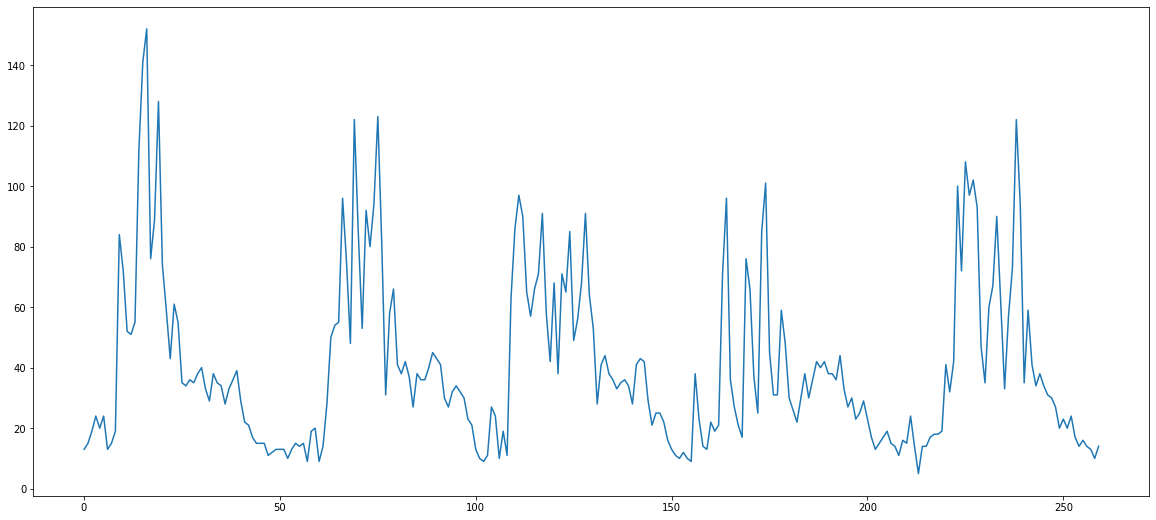

In [278]:
plt.plot(sj_predictions)

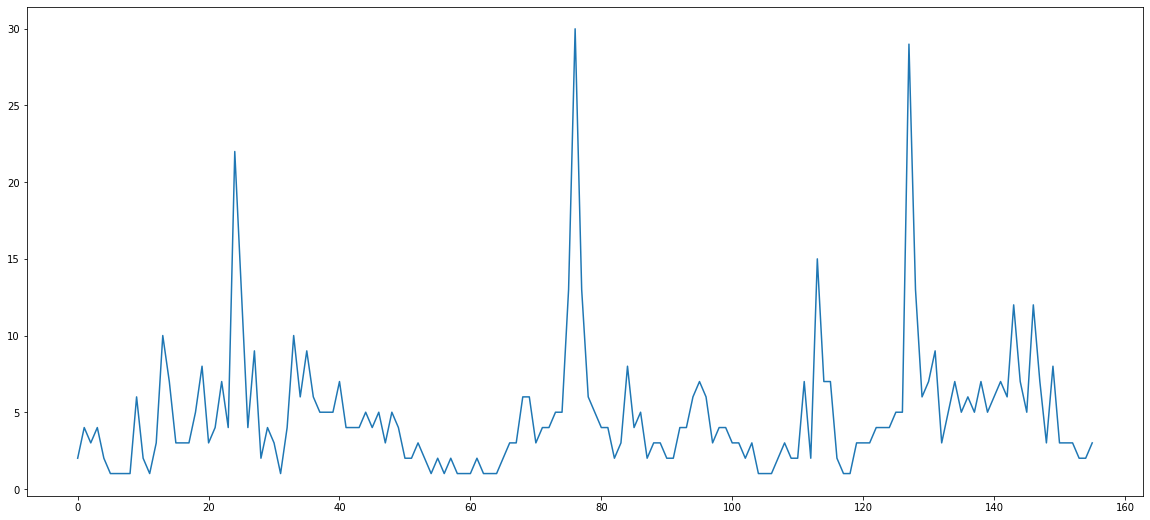

In [279]:
plt.plot(iq_predictions)